# Modelamiento Geológico 3D y Clasificación Automatizada de Sondajes con Machine Learning
**Autor:** Pablo Toledo | **Fecha:** 01/12/2025

---

1. **El Por Qué**

En la etapa avanzada de exploración y delineación de recursos, la interpretación geológica de los sondajes (logging) suele ser subjetiva y lenta. En sistemas **IOCG** complejos, donde la mineralización de Cobre-Oro está íntimamente ligada a zonaciones de alteración invisibles al ojo humano (ej. potásica vs. sódica), es crítico definir unidades geometalúrgicas consistentes.
El objetivo de este notebook es demostrar cómo el Machine Learning no supervisado puede procesar datos multi-elementales de perforación para generar un modelo geológico 3D objetivo, reduciendo la incertidumbre en la continuidad del cuerpo mineralizado y acelerando la toma de decisiones.

2. **El Cómo**

Se simuló una campaña de perforación completa ("Drilling Campaign") que corta un sistema tipo Mantoverde, integrando leyes, alteraciones y petrofísica.
**Flujo de Trabajo:**
1.  **Simulación de Perforación (Drillhole Simulation):** Generación de 4 sondajes sintéticos estratégicos con desviación natural (survey) y muestreo metro a metro:
    * **DH-DISCOVERY:** Pozo que intersecta el núcleo de alta ley.
    * **DH-DEEP:** Pozo profundo para probar la raíz del sistema.
    * **DH-PROXIMAL/DISTAL:** Pozos para definir los límites estériles.
2.  **Geoquímica de Downhole:** Modelamiento de la respuesta geoquímica en profundidad, correlacionando leyes económicas (Cu, Au, Co) con trazadores de alteración (Fe, K, Na, S) y respuesta geofísica (MagSus).
3.  **Clustering Automatizado (K-Means + PCA):** Aplicación de algoritmos de agrupación para "loguear" los sondajes matemáticamente. La IA clasifica cada metro de roca en dominios geológicos naturales (ej. *Núcleo*, *Halo de Pirita*, *Distal*) sin intervención humana, basándose puramente en la huella química.

3. **El Resultado**

La herramienta entrega visualizaciones avanzadas que validan la geometría del depósito:
* **Modelo 3D Interactivo:** Un visualizador tridimensional donde los sondajes se colorean automáticamente por el "Dominio", revelando la forma del cuerpo mineralizado (el "Target") y sus halos.
* **Strip Logs Inteligentes:** Gráficos de pozo (Downhole Plots) que contrastan la ley de Cobre con la Susceptibilidad Magnética, permitiendo validar visualmente la correlación entre magnetita y mineralización.
* **Consistencia:** Se elimina el sesgo del geólogo en el logging, asegurando que lo que se define como "Mena" en un pozo tenga las mismas características químicas que en otro.

---

### Referencias Principales:
* Capstone Copper (2024). Mantoverde Mine NI 43-101 Technical Report. (Base para las leyes y geometrías).
* Skirrow, R.G. et al. (2002). Chemical and mineralogical vectors to IOCG deposits. Geoscience Australia.
* Ehrig, K. et al. (2012). The Olympic Dam Iron Oxide Cu-U-Au-Ag Deposit: Formation and alteration zoning.
* Hill, E.J. et al. (2021). Machine learning for automated drill core logging. Economic Geology.

* Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.

In [1]:
##_0_LIBRERÍAS Y CONFIGURACIÓN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

np.random.seed(42)
sns.set_theme(style="whitegrid", palette="viridis")

In [6]:
##_1_##GENERACIÓN DE DATOS DE SONDAJES
def generar_sondaje_detallado(pozo_id, collar_x, collar_y, collar_z, azi, dip, largo, target_loc):
    """
    Simula un sondaje metro a metro con geoquímica IOCG realista.
    """
    tx, ty, tz = target_loc
    rows = []

    # Coordenadas actuales del trépano
    cx, cy, cz = collar_x, collar_y, collar_z

    for depth in range(0, largo, 2): # Muestreo cada 2 metros
        # Desviación natural (El pozo se chueca un poco)
        dip += np.random.normal(0, 0.05)
        azi += np.random.normal(0, 0.2)

        # Trigonometría para nuevas coordenadas
        rad_dip, rad_azi = np.radians(dip), np.radians(azi)
        dx = 2 * np.cos(rad_dip) * np.sin(rad_azi)
        dy = 2 * np.cos(rad_dip) * np.cos(rad_azi)
        dz = 2 * np.sin(rad_dip)

        cx += dx; cy += dy; cz += dz

        # MODELO GEOQUÍMICO (LA "INTELIGENCIA" DEL YACIMIENTO)
        dist = np.sqrt((cx - tx)**2 + (cy - ty)**2 + (cz - tz)**2)

        # MENA (Cobre-Oro-Cobalto)
        # Solo sube drásticamente si estamos en el núcleo (<100m)
        ley_cu = 0.05 + (5000 / (dist**1.5 + 10)) * np.random.normal(1, 0.8)
        ley_au = 0.01 + (200 / (dist**1.5 + 50)) * np.random.normal(1, 1.2)
        # El Cobalto se concentra en el borde de la pirita (halo de 150m)
        anillo_co = np.exp(-((dist - 150)**2) / 5000) * 1000
        ley_co = 10 + anillo_co + np.random.normal(0, 20)

        # ALTERACIÓN (Elementos Mayores)
        # Hierro: Alto en el centro (Magnetita)
        ley_fe = 3.0 + (55 / (dist/100 + 1)) + np.random.normal(0, 2)
        # Potasio vs Sodio: K alto cerca, Na alto lejos
        ley_k = 0.5 + (5 / (dist/150 + 1)) * np.random.normal(1, 0.3)
        ley_na = 4.0 - (3.5 / (dist/300 + 1)) * np.random.normal(1, 0.1)
        # Azufre: Alto en el sistema (Sulfuros), bajo afuera
        ley_s = 0.1 + (6 / (dist/80 + 1)) + np.random.normal(0, 0.5)

        # PATHFINDERS (Distales)
        # Manganeso y Zinc suben cuando te alejas
        ley_mn = 200 + (dist * 0.5) + np.random.normal(0, 50)
        ley_zn = 50 + (dist * 0.2) + np.random.normal(0, 10)

        # FÍSICA (MagSus y Densidad)
        magsus = 100 + (20000 / (dist/40 + 1)) + np.random.normal(0, 200) # Magnetita
        densidad = 2.7 + (ley_fe / 30) # Correlación directa Fe-Densidad

        # GEOTECNIA (RQD)
        # Zona de falla en el centro = Roca mala
        rqd = 100 - (2000 / (dist + 20)) + np.random.normal(0, 10)

        # Guardar datos
        rows.append([pozo_id, cx, cy, cz, depth,
                     ley_cu, ley_au, ley_co, ley_fe, ley_s, ley_k, ley_na,
                     ley_mn, ley_zn, magsus, densidad, rqd])

    cols = ['PozoID', 'East', 'North', 'Elev', 'Depth',
            'Cu', 'Au', 'Co', 'Fe', 'S', 'K', 'Na', 'Mn', 'Zn',
            'MagSus', 'Densidad', 'RQD']

    df = pd.DataFrame(rows, columns=cols)
    # Limpieza básica (no valores negativos)
    df[cols[5:]] = df[cols[5:]].clip(lower=0.001)
    return df

# GENERAR LA CAMPAÑA (4 POZOS ESTRATÉGICOS)
target = (350500, 7050500, 400) # El tesoro

# 1. Distal (Lejos)
dh1 = generar_sondaje_detallado("DH-DISTAL", 349500, 7050500, 900, 90, -60, 600, target)
# 2. Proximal (Pasa cerca, halo de pirita)
dh2 = generar_sondaje_detallado("DH-PROXIMAL", 350200, 7050500, 900, 90, -70, 700, target)
# 3. Discovery (Le pega al centro)
dh3 = generar_sondaje_detallado("DH-DISCOVERY", 350450, 7050500, 900, 90, -85, 800, target)
# 4. Profundo (Corta la raíz)
dh4 = generar_sondaje_detallado("DH-DEEP", 350500, 7050600, 900, 180, -80, 900, target)

# Unir todo
df_holes = pd.concat([dh1, dh2, dh3, dh4])
print(f"Base de Datos de Sondajes: {len(df_holes)} metros (Muestreo cada 2m).")




Base de Datos de Sondajes: 1500 metros (Muestreo cada 2m).


In [8]:
##_2_MACHINE LEARNING: CLASIFICACIÓN AUTOMÁTICA DE DOMINIOS (CLUSTERING)
print("Aplicando Ml para identificar zonas mineralizadas...")

# Usamos Geoquímica Vectorial para clasificar
features_ml = ['Cu', 'Fe', 'K', 'Na', 'S', 'Mn', 'MagSus', 'Co']

# Estandarizar (Importante porque MagSus es gigante y Cu es pequeño)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_holes[features_ml])

# PCA (Reducir ruido y ver vectores principales)
pca = PCA(n_components=2)
coords_pca = pca.fit_transform(X_scaled)
df_holes['PC1'] = coords_pca[:, 0]
df_holes['PC2'] = coords_pca[:, 1]

# K-Means (Buscamos 4 zonas naturales)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_holes['Cluster'] = kmeans.fit_predict(X_scaled)

# Interpretación Automática de Clusters (Darles nombre geológico)
# El cluster con más Cobre es la Mena. El con más Mn es Distal.
resumen = df_holes.groupby('Cluster')[features_ml].mean()
id_mena = resumen['Cu'].idxmax()
id_distal = resumen['Mn'].idxmax()
id_pirita = resumen['S'].idxmax() # Zona de Cobalto/Pirita

def etiquetar_cluster(c):
    if c == id_mena: return "1. NÚCLEO (Cu-Au-Fe)"
    elif c == id_distal: return "4. DISTAL (Mn-Zn)"
    elif c == id_pirita: return "2. HALO PIRITA (S-Co)"
    else: return "3. PROXIMAL (K-Fe)"

df_holes['Dominio'] = df_holes['Cluster'].apply(etiquetar_cluster)


Aplicando Ml para identificar zonas mineralizadas...


Generando Registros de Pozo (Strip Logs) con doble eje...


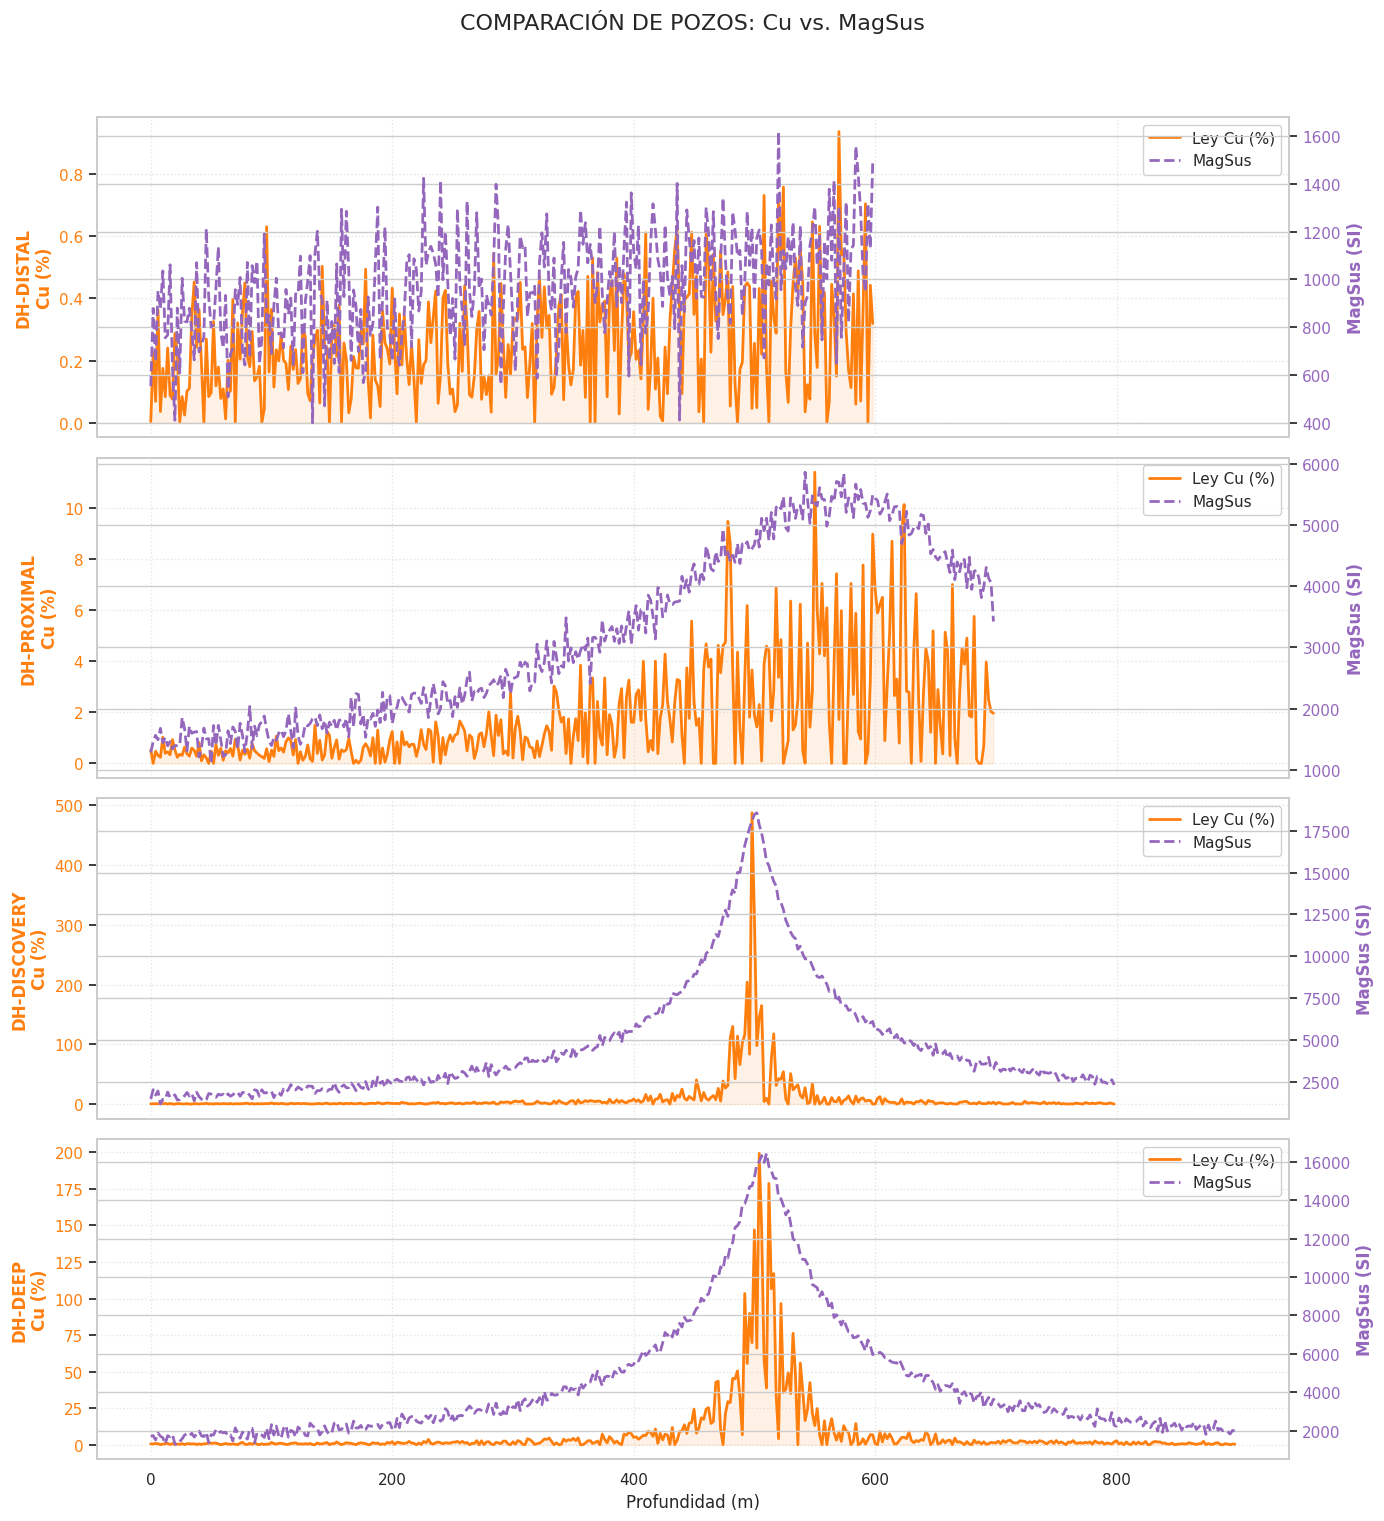

In [9]:
##_3_VISUALIZACIÓN: REGISTROS DE POZOS
print("Generando Registros de Pozo (Strip Logs) con doble eje...")

fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Colores para diferenciar
color_cu = 'tab:orange'
color_mag = 'tab:purple'

for i, pid in enumerate(['DH-DISTAL', 'DH-PROXIMAL', 'DH-DISCOVERY', 'DH-DEEP']):
    data = df_holes[df_holes['PozoID'] == pid]
    ax1 = axes[i]

    # EJE 1: COBRE (Izquierda - Naranja)
    ax1.set_ylabel(f"{pid}\nCu (%)", color=color_cu, fontsize=12, fontweight='bold')
    line1 = ax1.plot(data['Depth'], data['Cu'], color=color_cu, lw=2, label='Ley Cu (%)')
    ax1.fill_between(data['Depth'], 0, data['Cu'], color=color_cu, alpha=0.1)
    ax1.tick_params(axis='y', labelcolor=color_cu)
    ax1.grid(True, linestyle=':', alpha=0.5)

    # EJE 2: MAGSUS (Derecha - Morado)
    ax2 = ax1.twinx()
    ax2.set_ylabel("MagSus (SI)", color=color_mag, fontsize=12, fontweight='bold')
    line2 = ax2.plot(data['Depth'], data['MagSus'], color=color_mag, lw=2, linestyle='--', label='MagSus')
    ax2.tick_params(axis='y', labelcolor=color_mag)

    # Leyenda
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right', frameon=True, facecolor='white', framealpha=0.9)

    if i == 3:
        ax1.set_xlabel("Profundidad (m)", fontsize=12)

plt.suptitle("COMPARACIÓN DE POZOS: Cu vs. MagSus", y=0.98, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Dejamos el 5% superior libre para el título
plt.show()


In [10]:
##_4_VISUALIZACIÓN 3D: EL MODELO DE SONDAJES
print("Generando Modelo 3D de Sondajes...")

fig_3d = px.scatter_3d(
    df_holes, x='East', y='North', z='Elev',
    color='Dominio',
    color_discrete_map={
        "1. NÚCLEO (Cu-Au-Fe)": "red",
        "2. HALO PIRITA (S-Co)": "yellow",
        "3. PROXIMAL (K-Fe)": "orange",
        "4. DISTAL (Mn-Zn)": "blue"
    },
    hover_data={'PozoID':True, 'Depth':True, 'Cu':':.2f', 'Au':':.2f', 'Co':':.0f', 'MagSus':':.0f'},
    title="Campaña de Exploración: Dominios Identificados por Machine Learning",
    opacity=0.8
)

fig_3d.update_traces(marker=dict(size=3, line=dict(width=0))) # Estilo traza fina
fig_3d.update_layout(template="plotly_dark", height=800, legend=dict(orientation="h", y=-0.1))

# Target Real para referencia
fig_3d.add_scatter3d(x=[350500], y=[7050500], z=[400], mode='markers',
                     marker=dict(size=15, color='lime', symbol='diamond'), name='TARGET')

fig_3d.show()

Generando Modelo 3D de Sondajes...
